In [1]:
#!pip install pytesseract
#!pip install tensorflow
#!pip install keras
from sklearn.preprocessing import LabelEncoder

In [2]:
import cv2
from sklearn.preprocessing import LabelEncoder
from keras.models import model_from_json
import shutil
from os.path import splitext,basename
from matplotlib import pyplot as plt
import pytesseract
import imutils
import matplotlib.gridspec as gridspec
import numpy as np
#import easyocr # easyocr : karakterlerin tanınıp okunabilmesi için gerekli kütüphane

In [3]:
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)

In [ ]:
def predict_from_model(image,model,labels):
        image = cv2.resize(image,(80,80))
        image = np.stack((image,)*3, axis=-1)
        prediction = labels.inverse_transform([np.argmax(model.predict(image[np.newaxis,:]))])
        return prediction

In [4]:
wpod_net_path = "wpod-net.json"
wpod_net = load_model(wpod_net_path)

Loading model successfully...


In [5]:
def sort_contours(cnts,reverse = False):
    i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))
    return cnts

In [6]:
pytesseract.pytesseract.tesseract_cmd = r'C:\\\Program Files\\\Tesseract-OCR\\\tesseract.exe'

Detect 7 letters...
[INFO] Model loaded successfully...
[INFO] Labels loaded successfully...
34SEA90
Detect 8 letters...
[INFO] Model loaded successfully...
[INFO] Labels loaded successfully...
34SEA900
Detect 9 letters...
[INFO] Model loaded successfully...
[INFO] Labels loaded successfully...
34SEA9U00
Detect 8 letters...
[INFO] Model loaded successfully...
[INFO] Labels loaded successfully...
34SEA90D
Detect 8 letters...
[INFO] Model loaded successfully...
[INFO] Labels loaded successfully...
34SEA900
Detect 8 letters...
[INFO] Model loaded successfully...
[INFO] Labels loaded successfully...
34SEA90D
Detect 8 letters...
[INFO] Model loaded successfully...
[INFO] Labels loaded successfully...
34SEA90D
Detect 8 letters...
[INFO] Model loaded successfully...
[INFO] Labels loaded successfully...
34SEA90D


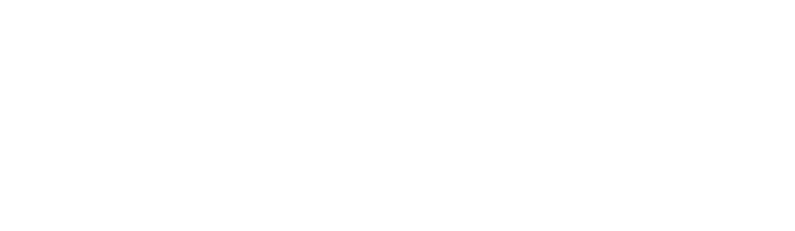

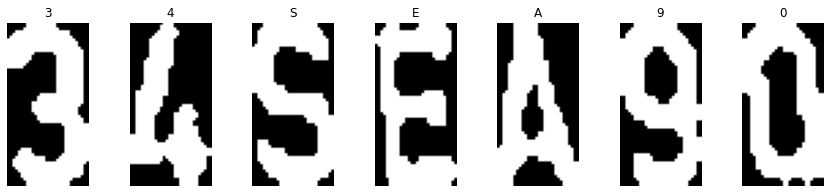

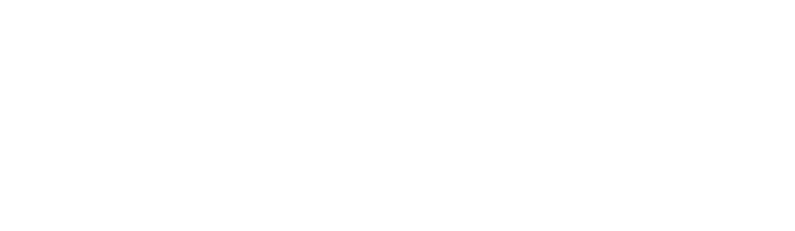

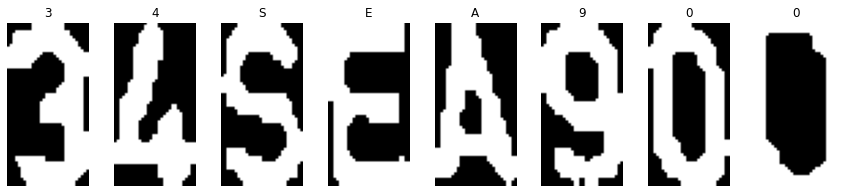

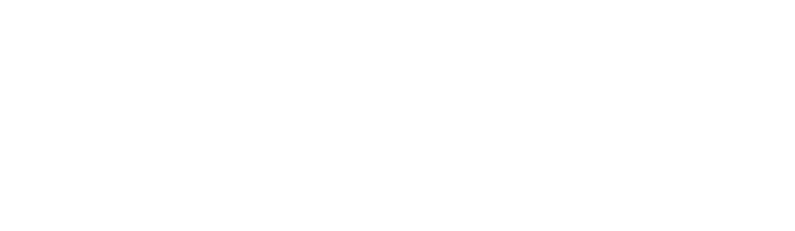

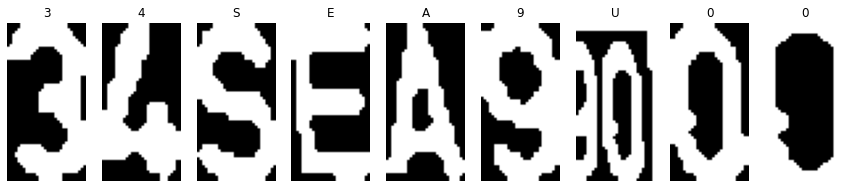

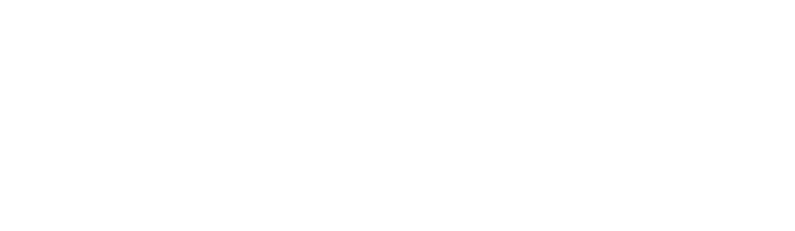

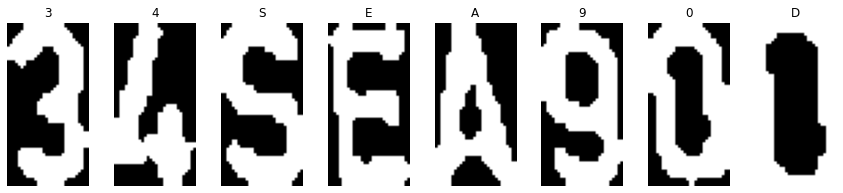

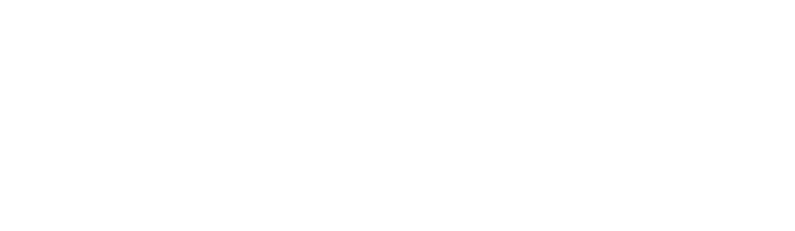

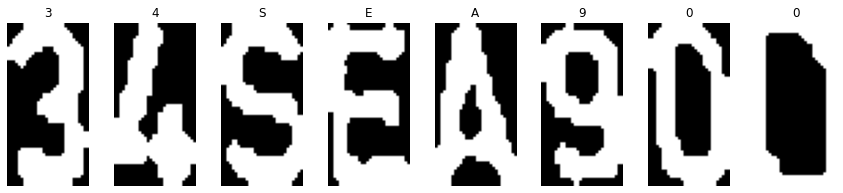

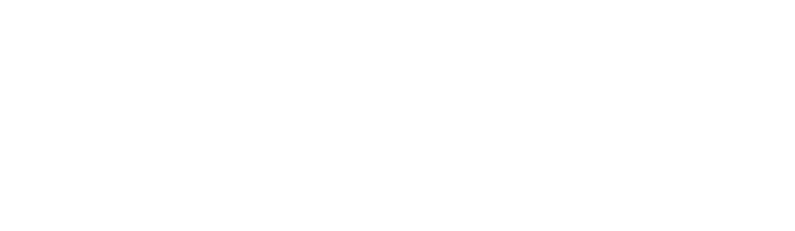

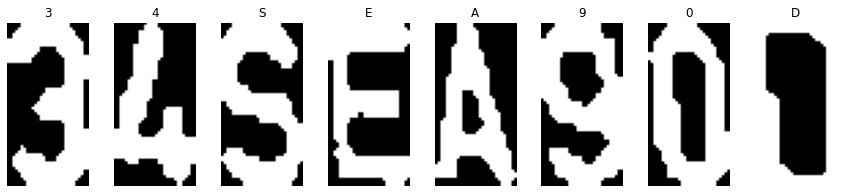

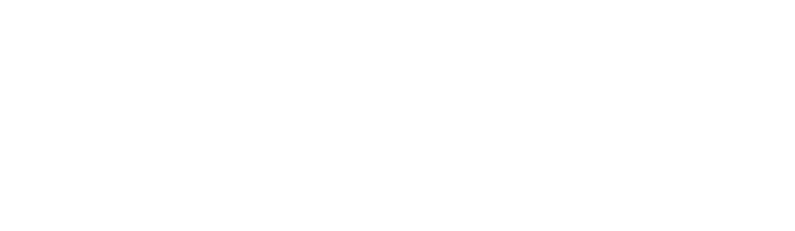

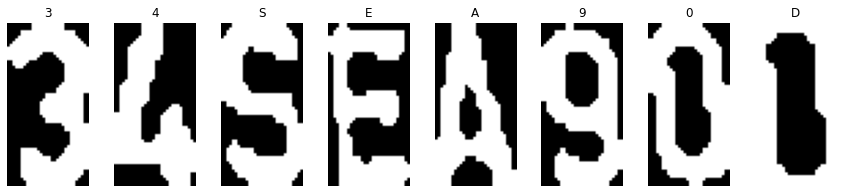

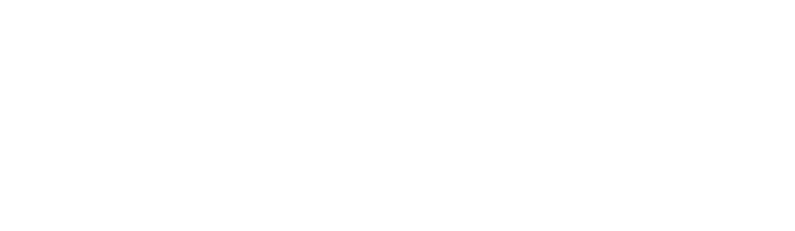

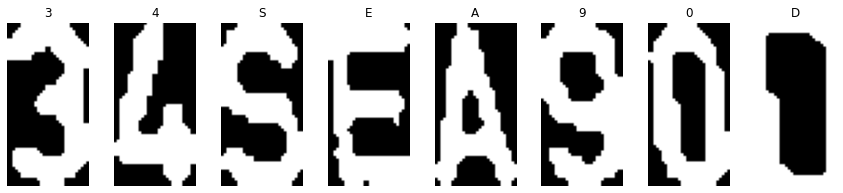

In [19]:
# kameraya bağlanma işlemi

video = cv2.VideoCapture("olsun.mp4") 

while True:
    
    ret,frame = video.read()  #videonun okunma işlemi buradaki frame değişkeni alacağımız görüntüleri tanımlıyor.
    
    grayformat = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY) # renkli görüntüye gerek duyulmadığından görüntü griye çevrildi.
    
    #cv2.imshow("original frame",frame)
    cv2.imshow("gray frame",grayformat) # gri görüntünün çıktısı
    
# filtreleme ve köşelerin belirginleştirilmesi işlemleri
    
    filtered = cv2.bilateralFilter(grayformat,11,17,17) #filtered frame from video
    
    #cv2.imshow("filtered img",filtered)
    
    edged = cv2.Canny(grayformat,127,127) # köşelerin belirginleştirilmesi
    
    cv2.imshow("Canny img",edged)
    
    keypoints = cv2.findContours(edged.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE) # çevresinin belirlenmesi
    
    contours = imutils.grab_contours(keypoints) # siyah arkaplanda beyaz gözükenlerin yakalanması

    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
    
    #print(contours)
    
    location = None
    for contour in contours:
        approx = cv2.approxPolyDP(contour, 10, True)
        if len(approx) == 4:
            location = approx
            break
            
    mask = np.zeros(grayformat.shape, np.uint8)
    new_image = cv2.drawContours(mask, [location], 0,255, -1)
    new_image = cv2.bitwise_and(frame, frame, mask=mask)
    
    new_image_gray = cv2.cvtColor(new_image,cv2.COLOR_BGR2GRAY)
    cv2.imshow("countours",new_image_gray)
    
    (x,y) = np.where(mask==255)
    (x1, y1) = (np.min(x), np.min(y))
    (x2, y2) = (np.max(x), np.max(y))
    cropped_image = grayformat[x1:x2+1, y1:y2+1]
    
    cv2.imshow("cropped image",cropped_image)
    thresh = cv2.adaptiveThreshold(cropped_image,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,11,2)
    cv2.imshow("thresh",thresh)
    kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
    thre_mor = cv2.morphologyEx(thresh, cv2.MORPH_DILATE, kernel3)
    cv2.imshow("threemor",thre_mor)
    #text = pytesseract.image_to_string(thre_mor)
    #print(text)
    
    cont, _  = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# creat a copy version "test_roi" of plat_image to draw bounding box
    test_roi = cropped_image.copy()

# Initialize a list which will be used to append charater image
    crop_characters = []

# define standard width and height of character
    digit_w, digit_h = 30, 60

    for c in sort_contours(cont):
        (x, y, w, h) = cv2.boundingRect(c)
        ratio = h/w
        if 1<=ratio<=3.5: # Only select contour with defined ratio
            if h/cropped_image.shape[0]>=0.5: # Select contour which has the height larger than 50% of the plate
                
                cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2)

            # Sperate number and gibe prediction
                curr_num = thre_mor[y:y+h,x:x+w]
                curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
                _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                crop_characters.append(curr_num)
            
    print("Detect {} letters...".format(len(crop_characters)))            
    fig = plt.figure(figsize=(14,4))
    grid = gridspec.GridSpec(ncols=len(crop_characters),nrows=1,figure=fig)

    for i in range(len(crop_characters)):
        fig.add_subplot(grid[i])
        plt.axis(False)
        #plt.imshow(crop_characters[i],cmap="gray")
        
    # Load model architecture, weight and labels
    json_file = open('MobileNets_character_recognition.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    model.load_weights("License_character_recognition_weight.h5")
    print("[INFO] Model loaded successfully...")

    labels = LabelEncoder()
    labels.classes_ = np.load('license_character_classes.npy')
    print("[INFO] Labels loaded successfully...")
    
    def predict_from_model(image,model,labels):
        image = cv2.resize(image,(80,80))
        image = np.stack((image,)*3, axis=-1)
        prediction = labels.inverse_transform([np.argmax(model.predict(image[np.newaxis,:]))])
        return prediction
    
    
    fig = plt.figure(figsize=(15,3))
    cols = len(crop_characters)
    grid = gridspec.GridSpec(ncols=cols,nrows=1,figure=fig)

    final_string = ''
    for i,character in enumerate(crop_characters):
        fig.add_subplot(grid[i])
        title = np.array2string(predict_from_model(character,model,labels))
        plt.title('{}'.format(title.strip("'[]"),fontsize=20))
        final_string+=title.strip("'[]")
        plt.axis(False)
        plt.imshow(character,cmap='gray')

    print(final_string)
#plt.savefig('final_result.png', dpi=300)
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    if cv2.waitKey(1) & 0xFF == ord('q'): # 300 ms de framelerin alınması ve 'q' tuşuna tıklanıldığı takdirde çıkış.
        break        
video.release()
cv2.destroyAllWindows()
    
    